In [1]:
import sys
sys.path.append('/media/data/studia/sieci_neuronowe_7_sem')
import abc
%load_ext autoreload
%autoreload 2

import random

from perceptron_adaline.data_generation import generate_data
import numpy as np

from perceptron_adaline.perceptron import Perceptron



In [2]:
class BaseModel(abc.ABC):
    def __init__(self, size, interval):
        self.weights = self._init_weights(size, (-interval, interval))

    @abc.abstractmethod
    def forward(self, x):
        pass

    @staticmethod
    def _init_weights(size, interval):
        return np.random.uniform(*interval, size)

    def update_weights(self, learning_rate, delta):
        self.weights += learning_rate * delta


class Perceptron(BaseModel):
    def __init__(self, size, theta=0, interval=1, bipolar=False):
        super().__init__(size, interval)
        self._theta = theta
        self._bipolar = bipolar

    def forward(self, x):
        result = x.dot(self.weights)
        activated = (result > self._theta).astype(float)
        if self._bipolar:
            activated = activated * 2 - 1
        return activated
        

class Adaline(BaseModel):
    def __init__(self, size, interval=1):
        super().__init__(size, interval)

    def forward(self, x):
        return x.dot(self.weights)

    
from enum import Enum, auto


class ModelType(Enum):
    PERCEPTRON = auto()
    ADALINE = auto()
    
class TrainingType(Enum):
    SGD = auto()
    BATCH = auto()
    
    
def train(model, x, y,
          learning_rate,
          bias,
          bipolar,
          step_func,
          break_func):

    if bipolar:
        y = y * 2. - 1.

    if bias:
        x = np.concatenate((np.ones((len(x), 1)), x), axis=1)

    epochs = 0

    while (True):
        epochs += 1
        delta = step_func(model, x, y, learning_rate)
        if break_func(delta):
            break

    return epochs


def sgd_step(model, x, y, learning_rate):
    delta_sum = 0.
    for xx, yy in zip(x, y):
        delta_sum += step(model, x, y, learning_rate)
    return delta_sum / len(x)
        

def step(model, x, y, learning_rate):
    y_pred = model.forward(x)
    error = y - y_pred
    delta = x.T.dot(error)
    model.update_weights(learning_rate, delta)
    return error


def perceptron_break(delta):
    return all(delta == 0)


def adaline_break(delta, tolerance):
    if any(np.isnan(delta)):
        raise OverflowError()
        
    loss = np.mean(delta**2)
    return loss < tolerance

[-1.35930715 -0.51124761 -0.05497669  0.79308286]
[-1.35930715  0.84805955  1.30433047] wagi


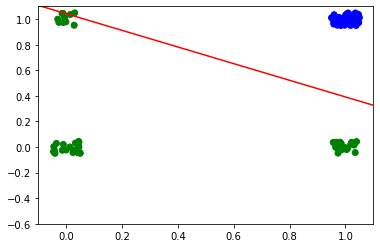

In [3]:
from functools import partial
from itertools import repeat

def generate_data(dataset_size, scale=0.01):
    def sample(population, size, label):
        delta = np.random.uniform(-scale, scale, size=(size, 2))
        return zip(delta + random.choices(population, k=size), repeat(label, size))
    positive = [[1, 1]]
    negative = [[0, 0], [0, 1], [1, 0]]
    return [*sample(negative, dataset_size // 2, 0), *sample(positive, dataset_size // 2, 1)]
            
            
xy = generate_data(100, scale=0.05)
random.shuffle(xy)
x, y = zip(*xy)
x, y = np.array(x), np.array(y)

bipolar = True
bias = True
model = Adaline(3, interval=1)
epochs = train(
    model, x, y,
    bias=bias,
    learning_rate=0.001,
    bipolar=bipolar,
    step_func=sgd_step,
    break_func=partial(adaline_break, tolerance=0.3)
)

import matplotlib.pyplot as plt
def plot_line(model, bias, eps=0.1):
    w0, w1, w2 = ([] if bias else [model._theta]) + list(model.weights)
    slope = -(w0 / w2) / (w0 / w1)  
    intercept = -w0 / w2
    plt.scatter(x[:, 0], x[:, 1], color=['b' if i else 'g' for i in y])
    xx = np.linspace(0 - eps, 1 + eps, 100)
    yy = slope * xx + intercept
    plt.plot(xx, yy, 'red')
    plt.xlim(-0 - eps, 1. + eps)
    plt.ylim(-0.5 - eps, 1. + eps)
    plt.show()
    
print(model.forward(np.array([[1, 0, 0], [1, 1, 0], [1, 0, 1], [1, 1, 1]])))
print(model.weights, 'wagi')
plot_line(model, bias=True)

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
SAVE_PATH = Path('/media/data/studia/sieci_neuronowe_7_sem/perceptron_adaline/raport/images')
plt.figure(figsize=(13, 8))
sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y)
plt.savefig(SAVE_PATH / '01_data.png')

NameError: name &#39;x&#39; is not defined

# Perceptron prosty
1. Ustal małe wartości początkowych wag i przyjmij wartość początkowego progu 𝜃. Przeprowadź eksperymenty z różnymi wartościami progu obserwując liczbę epok koniecznych do wyuczenia modelu.


In [478]:
import seaborn as sns
from tqdm import tqdm


NUM_RUNS = 19

def apply(train_func, grid, num_runs):
    results = {}
    for val in tqdm(grid):
        try:
            results[val] = [train_func(val) for _ in range(num_runs)]
        except OverflowError:
            results[val] = [25]
    return results


def plot(results, x_label, y_label,figsize=(10, 5), x_scale='linear', y_scale='linear'):
    plt.figure(figsize=figsize)
    sns.set_style('darkgrid')
    xs, results = zip(*[(x, yy) for x, y in results.items() for yy in y])
    ax = sns.lineplot(x=xs, y=results, markers=True, marker='o')
    ax.set(xlabel=x_label, xscale=x_scale, ylabel=y_label, yscale=y_scale)
    return ax


100%|██████████| 100/100 [00:05<00:00, 19.19it/s]


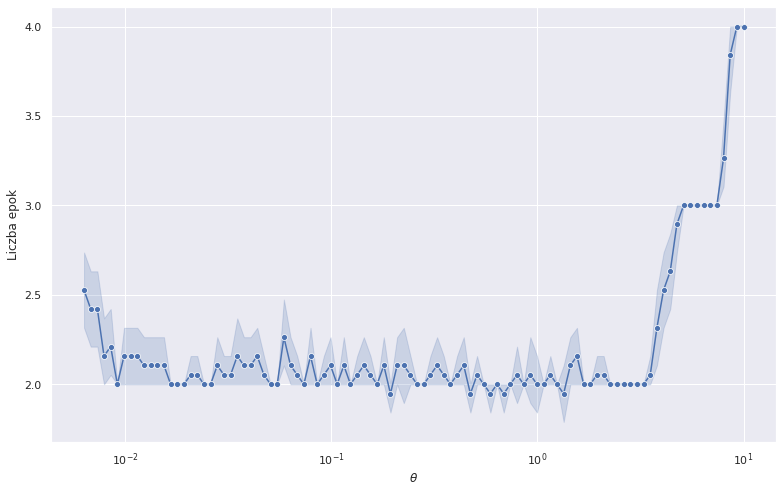

In [424]:
        
train_func = lambda theta: train(
    Perceptron(size=2, theta=theta, interval=1, bipolar=False),
    x, y,
    learning_rate=0.001,
    bias=False,
    bipolar=False,
    step_func=sgd_step,
    break_func=perceptron_break
)
theta_results = apply(train_func, np.logspace(-2.2, 1, 100), NUM_RUNS)

p = plot(
    theta_results,
    r'$\theta$',
    'Liczba epok',
    (13, 8),
    x_scale='log'
)
# p.set(xticks=np.arange(0, 10))
plt.savefig(SAVE_PATH / '02_per_theta.png')

2.Ustal dynamiczny próg(użyj bias). Niech zakres początkowych wartości wag mieści się w przedziale -1.0  do  1.0.Prowadzić kolejne eksperymenty z uczeniem neuronu, zmieniając  zakres  początkowych  losowych  wartości  wag  w  sposób  krokowy  na przykład –0.8  do  +0.8; -0.5  do  0.5; -0.2 do 0.2. itd. Czy ma to wpływ na szybkość 
uczenia?  Czy można  znaleźć  wartości  optymalne,  przy  których  neuron  uczy  się najszybciej?

100%|██████████| 99/99 [00:09<00:00,  9.96it/s]


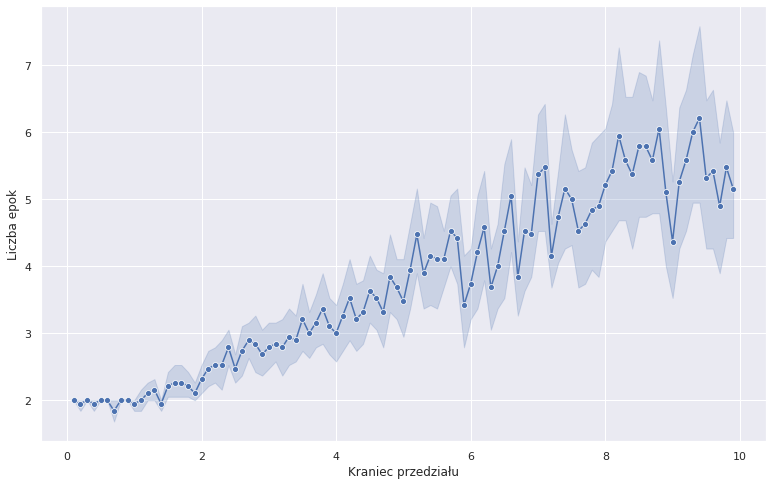

In [425]:
train_func = lambda i: train(
    Perceptron(size=3, interval=i, bipolar=False),
    x, y,
    learning_rate=0.001,
    bias=True,
    bipolar=False,
    step_func=sgd_step,
    break_func=perceptron_break
) 

interval_results = apply(train_func, np.arange(0.1, 10, step=0.1), NUM_RUNS)

plot(
    interval_results,
    r'Kraniec przedziału',
    'Liczba epok',
    (13, 8)
)
plt.savefig(SAVE_PATH / '03_per_interval.png')

3. Jaki wpływ na szybkość uczenia neuronu ma wartość współczynnika uczenia ? Wykonać badania zmieniając krokowo współczynnik uczenia

100%|██████████| 20/20 [00:01<00:00, 19.02it/s]


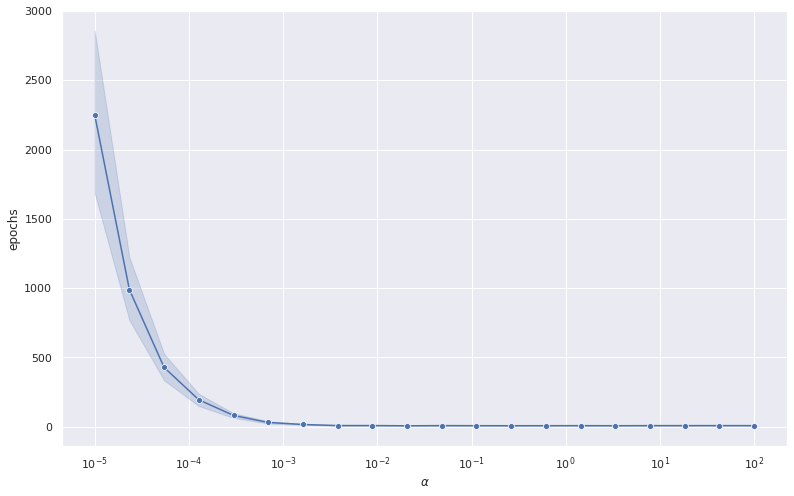

In [427]:
train_func = lambda i: train(
    Perceptron(size=3, interval=0.5, bipolar=False),
    x, y,
    learning_rate=i,
    bias=True,
    bipolar=False,
    step_func=step,
    break_func=perceptron_break
) 

learning_rate_results = apply(train_func, np.logspace(-5, 2, num=20), NUM_RUNS)

plot(
    learning_rate_results,
    r'$\alpha$',
    'epochs',
    (13, 8),
    x_scale='log',
)
plt.savefig(SAVE_PATH / '04_per_lr.png')

4.  Zastosować różne funkcje aktywacjineuronu:-progową unipolarną-progową bipolarnąJaki wpływ na szybkość uczenia mają zastosowane funkcje aktywacji?

100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


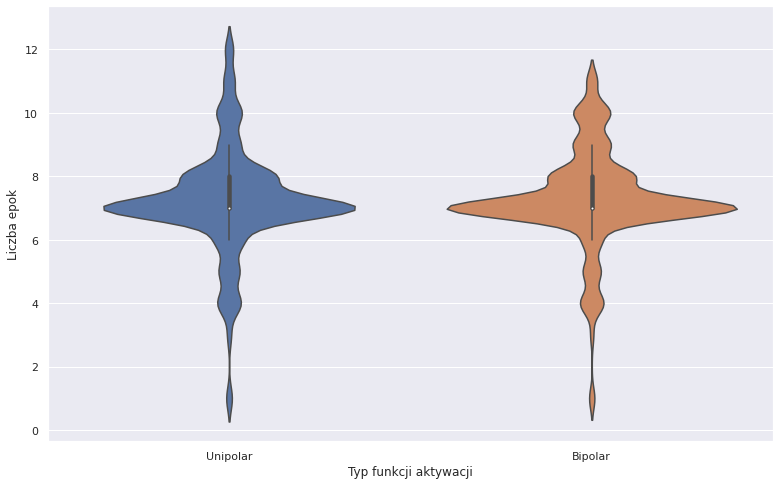

In [464]:
train_func = lambda i: train(
    Perceptron(size=3, interval=0.5, bipolar=i),
    x, y,
    learning_rate=1,
    bias=True,
    bipolar=i,
    step_func=step,
    break_func=perceptron_break
) 

uni_bi_polar_results = apply(train_func, [False, True], NUM_RUNS * 100)

plt.figure(figsize=(13, 8))
sns.set_style('darkgrid')
xs, results = zip(*[(x, yy) for x, y in uni_bi_polar_results.items() for yy in y])
xs = np.array(['Bipolar' if i else 'Unipolar' for i in xs])
results = np.array(results)
ax = sns.violinplot(x=xs, y=results)
ax.set(xlabel='Typ funkcji aktywacji', ylabel='Liczba epok')
# ax
plt.savefig(SAVE_PATH / '05_per_uni_bi.png')

# Adaline

1. Przyjąć dynamiczny próg (użyć bias). Niech zakres początkowych wartości wag mieści  się  w  przedziale -1.0  do  1.0.Prowadzić  kolejne  eksperymenty  z  uczeniem neuronu, zmieniając zakres początkowych losowych wartości wag w sposób krokowy 
na przykład –0.8 do +0.8; -0.5 do 0.5; -0.2 do 0.2. itd. Czy ma to wpływ na szybkość uczenia?  Czy  można  znaleźć  wartości  optymalne,  przy  których  neuron  uczy  się najszybciej?

100%|██████████| 98/98 [00:03<00:00, 30.60it/s]


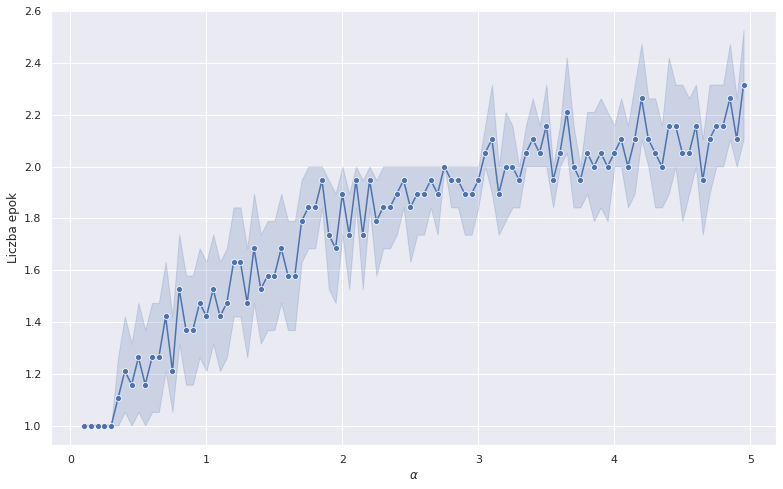

In [465]:
train_func = lambda i: train(
    Adaline(size=3, interval=i),
    x, y,
    learning_rate=0.001,
    bias=True,
    bipolar=False,
    step_func=sgd_step,
    break_func=lambda delta: adaline_break(delta, tolerance=0.1)
) 

adaline_interval = apply(train_func, np.arange(0.1, 5, step=0.05), NUM_RUNS)

plot(
    adaline_interval,
    r'$\alpha$',
    'Liczba epok',
    (13, 8),
)
plt.savefig(SAVE_PATH / '06_ada_interval.png')

2. Jaki wpływ na szybkość uczenia neuronu ma wartość współczynnika uczenia𝜇? Wykonać badania zmieniając krokowo współczynnik uczenia

 56%|█████▋    | 113/200 [00:04<00:01, 51.28it/s]/home/michal/miniconda3/envs/tyro/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-334-91bd5d64adb9>:101: RuntimeWarning: overflow encountered in square
  loss = np.mean(delta**2)
<ipython-input-334-91bd5d64adb9>:14: RuntimeWarning: invalid value encountered in add
  self.weights += learning_rate * delta
 69%|██████▉   | 138/200 [00:04<00:01, 53.95it/s]<ipython-input-334-91bd5d64adb9>:81: RuntimeWarning: invalid value encountered in add
  delta_sum += step(model, x, y, learning_rate)
<ipython-input-334-91bd5d64adb9>:14: RuntimeWarning: overflow encountered in multiply
  self.weights += learning_rate * delta
100%|██████████| 200/200 [00:04<00:00, 43.35it/s]


[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), '$\\inf$']


<ipython-input-486-bea96366e65d>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(['0', '5', '10', '15', '20', r'$\inf$'])


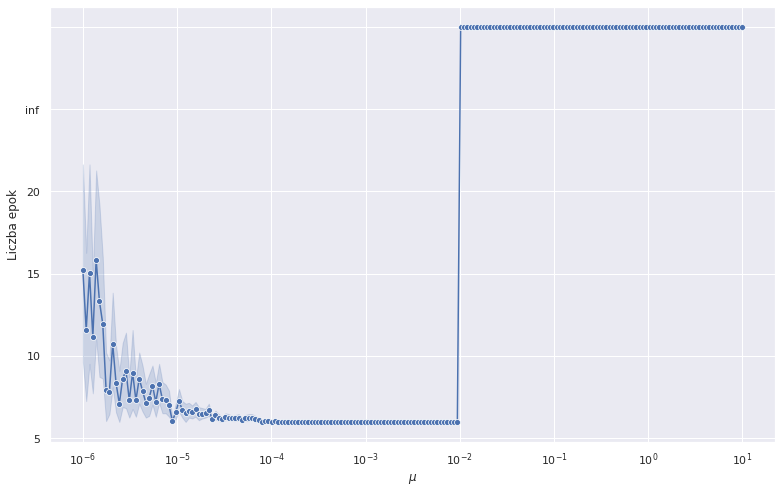

In [486]:
train_func = lambda i: train(
    Adaline(size=3, interval=1),
    x, y,
    learning_rate=i,
    bias=True,
    bipolar=False,
    step_func=sgd_step,
    break_func=lambda delta: adaline_break(delta, tolerance=1)
) 

adaline_learning_rate = apply(train_func, np.logspace(-6, 1, num=200), NUM_RUNS)
p = plot(
    adaline_learning_rate,
    r'$\mu$',
    'Liczba epok',
    (13, 8),
    x_scale='log'
)
l = p.get_yticklabels()
p.set_yticklabels(['0', '5', '10', '15', '20', r'$\inf$'])
plt.savefig(SAVE_PATH / '07_ada_lr.png')

3.  Jaki jest wpływ przyjętej wartości dopuszczalnego błędu?

100%|██████████| 39/39 [00:00<00:00, 51.44it/s]


<AxesSubplot:title={'center':'Zależność szybkości uczenia od współczynnika tolerancji'}, xlabel='tolerancja', ylabel='epochs'>

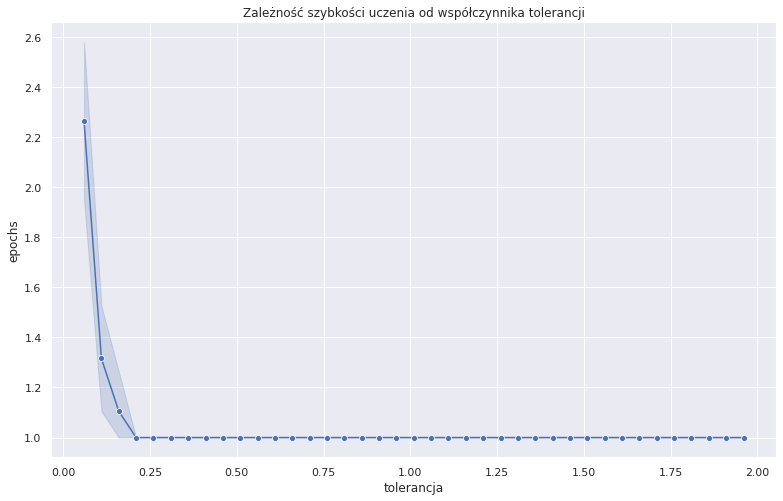

In [390]:
train_func = lambda i: train(
    Adaline(size=3, interval=1),
    x, y,
    learning_rate=0.001,
    bias=True,
    bipolar=False,
    step_func=sgd_step,
    break_func=lambda delta: adaline_break(delta, tolerance=i)
) 

adaline_tolerance = apply(train_func, np.arange(0.06, 2, step=0.05), NUM_RUNS)
plot(
    adaline_tolerance,
    r'tolerancja',
    'epochs',
    r'Zależność szybkości uczenia od współczynnika tolerancji',
    (13, 8),
)

4. Porównać uzyskane wyniki dla obu modeli z ćwiczenia 1(Perceptron i Adaline) 

<AxesSubplot:title={'center':'Zależność szybkości uczenia od progu $\\theta$'}, xlabel='$\\theta$', ylabel='epochs'>

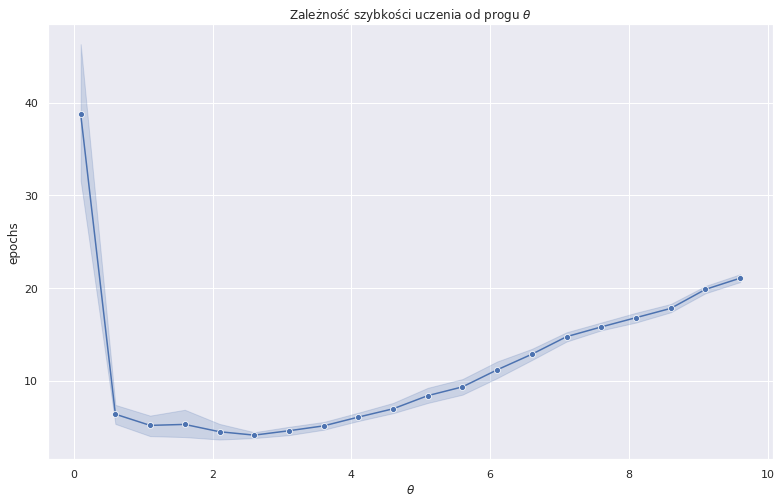